In [ ]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.output_parsers import BaseOutputParser

from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langgraph.graph import END, StateGraph

import os
import yaml
import ast
import json
import re

from pprint import pprint
from typing import Annotated, TypedDict

import pandas as pd
import sqlalchemy as sql

import plotly as pl
import plotly.express as px
import plotly.io as pio

from IPython.display import Image

In [ ]:
os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']
os.environ["GROQ_API_KEY"] = yaml.safe_load(open("../credentials.yml"))['groq']

OPENAI_LLM = ChatOpenAI(
    model = "gpt-4o-mini"
)

GROQ_LLM = ChatGroq(
    model="llama3-70b-8192",
)

llm = OPENAI_LLM

In [ ]:
routing_preprocessor_prompt = PromptTemplate(
    template="""
    You are an expert in routing decisions for a SQL database agent, a Charting Visualization Agent, and a Pandas Table Agent. Your job is to:
    
    1. Determine what the correct format for a Users Question should be for use with a SQL translator agent 
    2. Determine whether or not a chart should be generated or a table should be returned based on the users question.
    
    Use the following criteria on how to route the the initial user question:
    
    From the incoming user question, remove any details about the format of the final response as either a Chart or Table and return only the important part of the incoming user question that is relevant for the SQL generator agent. This will be the 'formatted_user_question_sql_only'. If 'None' is found, return the original user question.
    
    Next, determine if the user would like a data visualization ('chart') or a 'table' returned with the results of the SQL query. If unknown, not specified or 'None' is found, then select 'table'.  
    
    Return JSON with 'formatted_user_question_sql_only' and 'routing_preprocessor_decision'.
    
    INITIAL_USER_QUESTION: {initial_question}
    """,
    input_variables=["initial_question"]
)

routing_preprocessor = routing_preprocessor_prompt | llm | JsonOutputParser()

routing_preprocessor

PromptTemplate(input_variables=['initial_question'], template="\n    You are an expert in routing decisions for a SQL database agent, a Charting Visualization Agent, and a Pandas Table Agent. Your job is to:\n    \n    1. Determine what the correct format for a Users Question should be for use with a SQL translator agent \n    2. Determine whether or not a chart should be generated or a table should be returned based on the users question.\n    \n    Use the following criteria on how to route the the initial user question:\n    \n    From the incoming user question, remove any details about the format of the final response as either a Chart or Table and return only the important part of the incoming user question that is relevant for the SQL generator agent. This will be the 'formatted_user_question_sql_only'. If 'None' is found, return the original user question.\n    \n    Next, determine if the user would like a data visualization ('chart') or a 'table' returned with the results of 

In [ ]:
PATH_DB = "sqlite:///data/database-sql-transactions/leads_scored.db"

db = SQLDatabase.from_uri(PATH_DB)

In [ ]:
def extract_sql_code(text):
    sql_code_match = re.search(r'```sql(.*?)```', text, re.DOTALL)
    if sql_code_match:
        sql_code = sql_code_match.group(1).strip()
        return sql_code
    else:
        sql_code_match = re.search(r"sql(.*?)'", text, re.DOTALL)
        if sql_code_match:
            sql_code = sql_code_match.group(1).strip()
            return sql_code
        else:
            return None

# extract_sql_code("```sql\nSELECT * FROM Transactions\n```")


class SQLOutputParser(BaseOutputParser):
    def parse(self, text: str):
        sql_code = extract_sql_code(text)
        if sql_code is not None:
            return sql_code
        else:
            # Assume ```sql wasn't used
            return text

prompt_sqlite = PromptTemplate(
    input_variables=['input', 'table_info', 'top_k'],
    template="""
    You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
    
    Do not use a LIMIT clause with {top_k} unless a user specifies a limit to be returned.
    
    Return SQL in ```sql ``` format.
    
    Only return a single query if possible.
    
    Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
    
    Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
    
    Pay attention to use date(\'now\') function to get the current date, if the question involves "today".
        
    Only use the following tables:
    {table_info}
    
    Question: {input}'
    """
)

sql_generator = (
    create_sql_query_chain(
        llm = llm,
        db = db,
        k = int(1e7),
        prompt = prompt_sqlite
    ) 
    | SQLOutputParser() # NEW SQLCodeExtactor
)

In [ ]:
sql_engine = sql.create_engine(PATH_DB)

conn = sql_engine.connect()

In [ ]:
# Creates new instructions specifically for the Chart Generator Agent from the User Question
prompt_chart_instructions = PromptTemplate(
    template="""
    You are a supervisor that is an expert in providing instructions to a chart generator agent for plotting. 
    
    You will take a question that a user has and the data that was generated to answer the question, and create instructions to create a chart from the data that will be passed to a chart generator agent.
    
    USER QUESTION: {question}
    
    DATA: {data}
    
    Formulate "chart generator instructions" by informing the chart generator of what type of plotly plot to use (e.g. bar, line, scatter, etc) to best represent the data. 
    
    Come up with an informative title from the user's question and data provided. Also provide X and Y axis titles.
    
    Instruct the chart generator to use the following theme colors, sizes, etc:
    
    - Start with the "plotly_white" template
    - Use a white background
    - Use this color for bars and lines:
        'blue': '#3381ff',
    - Base Font Size: 8.8 (Used for x and y axes tickfont, any annotations, hovertips)
    - Title Font Size: 13.2
    - Line Size: 0.65 (specify these within the xaxis and yaxis dictionaries)
    - Add smoothers or trendlines to scatter plots unless not desired by the user
    - Do not use color_discrete_map (this will result in an error)
    - Hover tip size: 8.8
    
    Return your instructions in the following format:
    CHART GENERATOR INSTRUCTIONS: FILL IN THE INSTRUCTIONS HERE
    
    """,
    input_variables=['question', 'data']
)

chart_instructor = prompt_chart_instructions | llm | StrOutputParser()

chart_instructor

PromptTemplate(input_variables=['data', 'question'], template='\n    You are a supervisor that is an expert in providing instructions to a chart generator agent for plotting. \n    \n    You will take a question that a user has and the data that was generated to answer the question, and create instructions to create a chart from the data that will be passed to a chart generator agent.\n    \n    USER QUESTION: {question}\n    \n    DATA: {data}\n    \n    Formulate "chart generator instructions" by informing the chart generator of what type of plotly plot to use (e.g. bar, line, scatter, etc) to best represent the data. \n    \n    Come up with an informative title from the user\'s question and data provided. Also provide X and Y axis titles.\n    \n    Instruct the chart generator to use the following theme colors, sizes, etc:\n    \n    - Start with the "plotly_white" template\n    - Use a white background\n    - Use this color for bars and lines:\n        \'blue\': \'#3381ff\',\n   

In [ ]:
repl = PythonREPL()

# repl.run("A = 1; print(A)")

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


prompt_chart_generator = PromptTemplate(
    template = """
    You are an expert in creating data visualizations and plots using the plotly python library. You must use plotly or plotly.express to produce plots.
    
    Your job is to produce python code to generate visualizations.
    
    Create the python code to produce the requested visualization given the plot requested from the original user question and the input data. 
    
    The input data will be provided as a dictionary and will need converted to a pandas data frame before creating the visualization. 
    
    The output of the plotly chart should be stored as a JSON object with pio.to_json() and then to a dictionary. 
    
    Make sure to add: import plotly.io as pio
    Make sure to print the fig_dict
    Make sure to import json
    
    Here's an example of converting a plotly object to JSON:
    
    import json
    import plotly.graph_objects as go
    import plotly.io as pio

    # Create a sample Plotly figure
    fig = go.Figure(data=go.Bar(y=[2, 3, 1]))

    # Convert the figure to JSON
    fig_json = pio.to_json(fig)
    fig_dict = json.loads(fig_json)
    
    print(fig_dict) # MAKE SURE TO DO THIS
    
    
    CHART INSTRUCTIONS: {chart_instructions}
    INPUT DATA: {data}
    
    Important Notes on creating the chart code:
    - Do not use color_discrete_map. This is an invalid property.
    - If bar plot, do not add barnorm='percent' unless user asks for it
    - If bar plot, do not add a trendline. Plotly bar charts do not natively support the trendline.  
    - For line plots, the line width should be updated on traces (example: # Update traces
fig.update_traces(line=dict(color='#3381ff', width=0.65)))
    - For Bar plots, the default line width is acceptable
    - Super important - Make sure to print(fig_dict)
    """,
    input_variables=["chart_instructions", "data"]
)

tools = [python_repl]

chart_generator = prompt_chart_generator.partial(tool_names=", ".join([tool.name for tool in tools])) | llm.bind_tools(tools)

In [ ]:
chart_generator

PromptTemplate(input_variables=['chart_instructions', 'data'], partial_variables={'tool_names': 'python_repl'}, template="\n    You are an expert in creating data visualizations and plots using the plotly python library. You must use plotly or plotly.express to produce plots.\n    \n    Your job is to produce python code to generate visualizations.\n    \n    Create the python code to produce the requested visualization given the plot requested from the original user question and the input data. \n    \n    The input data will be provided as a dictionary and will need converted to a pandas data frame before creating the visualization. \n    \n    The output of the plotly chart should be stored as a JSON object with pio.to_json() and then to a dictionary. \n    \n    Make sure to add: import plotly.io as pio\n    Make sure to print the fig_dict\n    Make sure to import json\n    \n    Here's an example of converting a plotly object to JSON:\n    \n    import json\n    import plotly.grap

In [ ]:
# * LANGGRAPH
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    user_question: str
    formatted_user_question_sql_only: str
    sql_query : str
    data: dict
    routing_preprocessor_decision: str
    chart_generator_instructions: str
    chart_plotly_code: str
    chart_plotly_json: dict
    chart_plotly_error: bool
    num_steps : int
    
def preprocess_routing(state):
    print("---ROUTER---")
    question = state.get("user_question")
    
    num_steps = state.get("num_steps")
    
    num_steps += 1
    
    # Chart Routing and SQL Prep
    response = routing_preprocessor.invoke({"initial_question": question})
    
    formatted_user_question_sql_only = response['formatted_user_question_sql_only']
    
    routing_preprocessor_decision = response['routing_preprocessor_decision']
    
    return {
        "formatted_user_question_sql_only": formatted_user_question_sql_only,
        "routing_preprocessor_decision": routing_preprocessor_decision,
        "num_steps": num_steps
    }
    


def generate_sql(state):
    print("---GENERATE SQL---")
    question = state.get("formatted_user_question_sql_only")
    
    # Handle case when formatted_user_question_sql_only is None:
    if question is None:
        question = state.get("user_question")
    
    num_steps = state.get("num_steps")
    
    num_steps += 1
    
    # Generate SQL
    sql_query = sql_generator.invoke({"question": question})
    
    return {"sql_query": sql_query, "num_steps": num_steps}


def convert_dataframe(state):
    print("---CONVERT DATA FRAME---")

    sql_query = state.get("sql_query")
    
    num_steps = state.get("num_steps")
    
    num_steps += 1
    
    # Remove trailing ' that gpt-3.5-turbo sometimes leaves
    sql_query = sql_query.rstrip("'")
    
    df = pd.read_sql(sql_query, conn)
    
    return {"data": dict(df), "num_steps": num_steps}


def decide_chart_or_table(state):
    print("---DECIDE CHART OR TABLE---")
    return "chart" if state.get('routing_preprocessor_decision') == "chart" else "table"

def instruct_chart_generator(state):
    print("---INSTRUCT CHART GENERATOR---")
    
    question = state.get("user_question")
    
    data = state.get("data")
    
    num_steps = state.get("num_steps")
    
    num_steps += 1
    
    chart_generator_instructions = chart_instructor.invoke({"question": question, "data": data})
    
    return {"chart_generator_instructions": chart_generator_instructions, "num_steps": num_steps}


    

def generate_chart(state):
    print("---GENERATE CHART---")
    
    chart_instructions = state.get("chart_generator_instructions")
    
    data = state.get("data")
    
    num_steps = state.get("num_steps")
    
    num_steps += 1
    
    # NEW: Charting Logic
    
    response = chart_generator.invoke({"chart_instructions": chart_instructions, "data": data})
    
    # Fix - if invalid tool calls
    try:
        code = dict(response)['tool_calls'][0]['args']['code']
    except: 
        code = dict(response)['invalid_tool_calls'][0]['args']
    
    result = repl.run(code)
    
    # Add plot to global environment
    globals()["chart_plotly_json"] = result
    
    chart_plotly_error = False
    if "error" in result[:40].lower():
        chart_plotly_error = True
    else:
        try:
            result_dict = ast.literal_eval(result)
        
            fig = pio.from_json(json.dumps(result_dict))

            fig.show()
        except:
            chart_plotly_error = True
        
    return {
        "chart_plotly_code": code, 
        "chart_plotly_json": result, 
        "chart_plotly_error": chart_plotly_error,
        "num_steps": num_steps,
    }
    
    
def state_printer(state):
    """print the state"""
    print("---STATE PRINTER---")
    print(f"User Question: {state['user_question']}")
    print(f"Formatted Question (SQL): {state['formatted_user_question_sql_only']}")
    print(f"SQL Query: \n{state['sql_query']}\n")
    print(f"Data: \n{pd.DataFrame(state['data'])}\n")
    print(f"Chart or Table: {state['routing_preprocessor_decision']}")
    
    if state['routing_preprocessor_decision'] == "chart":
        print(f"Chart Code: \n{pprint(state['chart_plotly_code'])}")
        print(f"Chart Error: {state['chart_plotly_error']}")
    
    print(f"Num Steps: {state['num_steps']}")

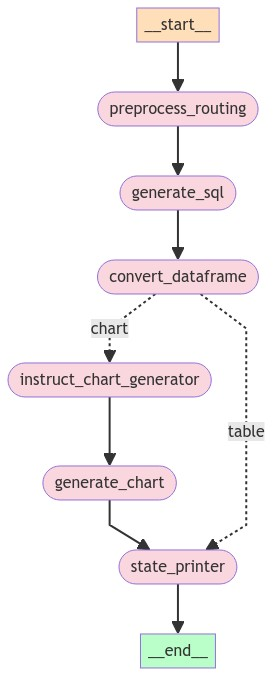

In [ ]:
# * WORKFLOW DAG

workflow = StateGraph(GraphState)

workflow.add_node("preprocess_routing", preprocess_routing)
workflow.add_node("generate_sql", generate_sql)
workflow.add_node("convert_dataframe", convert_dataframe)
workflow.add_node("instruct_chart_generator", instruct_chart_generator)
workflow.add_node("generate_chart", generate_chart)
workflow.add_node("state_printer", state_printer)

workflow.set_entry_point("preprocess_routing")
workflow.add_edge("preprocess_routing", "generate_sql")
workflow.add_edge("generate_sql", "convert_dataframe")

workflow.add_conditional_edges(
    "convert_dataframe", 
    decide_chart_or_table,
    {
        # Result : Step Name To Go To
        "chart":"instruct_chart_generator", # Path Chart
        "table":"state_printer" # Path State Printer
    }
)

workflow.add_edge("instruct_chart_generator", "generate_chart")
workflow.add_edge("generate_chart", "state_printer")
workflow.add_edge("state_printer", END)

app = workflow.compile()

Image(app.get_graph().draw_mermaid_png())

In [ ]:
QUESTION = """
Which 10 customers have the highest p1 probability of purchase who have NOT purchased "Learning Labs Pro - Paid Course"? 
"""
inputs = {"user_question": QUESTION, "num_steps": 0}
for s in app.stream(inputs):
    print(s)

---ROUTER---
{'preprocess_routing': {'formatted_user_question_sql_only': 'Which 10 customers have the highest p1 probability of purchase who have NOT purchased "Learning Labs Pro - Paid Course"?', 'routing_preprocessor_decision': 'table', 'num_steps': 1}}
---GENERATE SQL---
{'generate_sql': {'sql_query': 'SELECT "user_full_name", "user_email", "p1" \nFROM "leads_scored" \nWHERE "mailchimp_id" NOT IN (\n    SELECT "user_email" \n    FROM "transactions" \n    JOIN "products" ON "transactions"."product_id" = "products"."product_id" \n    WHERE "products"."description" = \'Learning Labs Pro - Paid Course\'\n) \nORDER BY "p1" DESC \nLIMIT 10;', 'num_steps': 2}}
---CONVERT DATA FRAME---
---DECIDE CHART OR TABLE---
{'convert_dataframe': {'data': {'user_full_name': 0            Kecia Johnson
1          Estel Abernathy
2      Peter Morar-Lebsack
3    Dr. Alana Hermann DDS
4          Bedford Farrell
5    Mr. Ephraim Ankunding
6           Doloris Larkin
7            Chase Pfeffer
8      Mr. Volne

In [ ]:
QUESTION = """
What are the total sales by month-year? Use suggested price as a proxy for revenue for each transaction and a quantity of 1. Make a chart of sales over time. 
"""
inputs = {"user_question": QUESTION, "num_steps": 0}
for s in app.stream(inputs):
    print(s)

---ROUTER---
{'preprocess_routing': {'formatted_user_question_sql_only': 'What are the total sales by month-year? Use suggested price as a proxy for revenue for each transaction and a quantity of 1.', 'routing_preprocessor_decision': 'chart', 'num_steps': 1}}
---GENERATE SQL---
{'generate_sql': {'sql_query': 'SELECT strftime(\'%Y-%m\', "purchased_at") AS "month_year", \n       SUM("suggested_price") AS "total_sales"\nFROM transactions\nJOIN products ON transactions."product_id" = products."product_id"\nGROUP BY "month_year"\nORDER BY "month_year";', 'num_steps': 2}}
---CONVERT DATA FRAME---
---DECIDE CHART OR TABLE---
{'convert_dataframe': {'data': {'month_year': 0     2018-04
1     2018-05
2     2018-06
3     2018-07
4     2018-08
5     2018-09
6     2018-10
7     2018-11
8     2018-12
9     2019-01
10    2019-02
11    2019-03
12    2019-04
13    2019-05
14    2019-06
15    2019-07
16    2019-08
17    2019-09
18    2019-10
19    2019-11
20    2019-12
21    2020-01
22    2020-02
23    

Python REPL can execute arbitrary code. Use with caution.


{'generate_chart': {'chart_plotly_code': "import pandas as pd\nimport plotly.graph_objects as go\nimport plotly.io as pio\nimport json\n\n# Provided input data\ninput_data = {\n    'month_year': [\n        '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',\n        '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',\n        '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',\n        '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',\n        '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',\n        '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',\n        '2020-10', '2020-11', '2020-12'\n    ],\n    'total_sales': [\n        9800.000000, 21950.000000, 5600.000000, 7500.000000, 7250.000000,\n        9350.000000, 13550.000000, 18750.000000, 11300.000000, 29883.333333,\n        11183.333333, 14216.666667, 21299.666667, 35523.000000, 59795.000000,\n        26445.500000, 28015.666667, 29490.000000, 57946.333333, 80941.333333,\n        51038.500000, 44712.666667, 